In [1]:
import tensorflow
import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense ,Conv2D ,Conv2DTranspose ,Dropout ,BatchNormalization ,Input ,MaxPooling2D ,concatenate
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
from tensorflow.keras.optimizers import Adam
from google.colab.patches import cv2_imshow

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
train_input_dir = '/content/gdrive/My Drive/train_input_870'
train_output_dir = '/content/gdrive/My Drive/train_output_870'
test_input_dir = '/content/gdrive/My Drive/test_input_20'
test_output_dir = ('/content/gdrive/My Drive/test_output_20')

In [4]:
def images(dir_train,dir_test):
  images = os.listdir(dir_train)
  images_ = os.listdir(dir_test)
  k = random.choice(images)
  k_ = random.choice(images_)
  file_train = dir_train + '/' + k
  file_test = dir_test + '/' + k_
  print(len(images))
  print(len(images_))
  img = cv2.resize(cv2.imread(file_train),(256,256))
  img_ = cv2.resize(cv2.imread(file_test),(256,256))
  #cv2_imshow(img)
  #cv2_imshow(img_)

In [5]:
images(train_input_dir,train_output_dir)

885
885


In [6]:
def conv_model(hidden_size):
    input_layer = Input((256,256,3))
    conv_1 = Conv2D(hidden_size * 1,(3,3),activation = "relu" ,padding = "same")(input_layer)
    conv_1 = Conv2D(hidden_size * 1,(3,3),activation = "relu" ,padding = "same")(conv_1)
    pool_1 = MaxPooling2D((2,2))(conv_1)


    conv_2 = Conv2D(hidden_size * 2,(3,3),activation = "relu" ,padding = "same")(pool_1)
    conv_2 = Conv2D(hidden_size * 2,(3,3),activation = "relu" ,padding = "same")(conv_2)
    pool_2 = MaxPooling2D((2,2))(conv_2)

    conv_3 = Conv2D(hidden_size * 4,(3,3),activation = "relu" ,padding = "same")(pool_2)
    conv_3 = Conv2D(hidden_size * 4,(3,3),activation = "relu" ,padding = "same")(conv_3)
    pool_3 = MaxPooling2D((2,2))(conv_3)

    conv_4 = Conv2D(hidden_size * 8,(3,3),activation = "relu" ,padding = "same")(pool_3)
    conv_4 = Conv2D(hidden_size * 8,(3,3),activation = "relu" ,padding = "same")(conv_4)
    pool_4 = MaxPooling2D((2,2))(conv_4)

    conv_m = Conv2D(hidden_size * 16,(3,3),activation = "relu" ,padding = "same")(pool_4)
    conv_m = Conv2D(hidden_size * 16,(3,3),activation = "relu" ,padding = "same")(conv_m)

    de_conv_4 = Conv2DTranspose(hidden_size * 8, (3, 3), strides=(2, 2), padding="same")(conv_m)
    de_conv_4 = concatenate([de_conv_4 , conv_4])
    de_conv_4 = Conv2D(hidden_size * 8, (3, 3), activation="relu", padding="same")(de_conv_4)
    de_conv_4 = Conv2D(hidden_size * 8, (3, 3), activation="relu", padding="same")(de_conv_4)

    de_conv_3 = Conv2DTranspose(hidden_size * 4, (3, 3), strides=(2, 2), padding="same")(de_conv_4)
    de_conv_3 = concatenate([de_conv_3 , conv_3])
    de_conv_3 = Conv2D(hidden_size * 4, (3, 3), activation="relu", padding="same")(de_conv_3)
    de_conv_3 = Conv2D(hidden_size * 4 ,(3, 3), activation="relu", padding="same")(de_conv_3)

    de_conv_2 = Conv2DTranspose(hidden_size * 2, (3, 3), strides=(2, 2), padding="same")(de_conv_3)
    de_conv_2 = concatenate([de_conv_2 , conv_2])
    de_conv_2 = Conv2D(hidden_size * 2, (3, 3), activation="relu", padding="same")(de_conv_2)
    de_conv_2 = Conv2D(hidden_size * 2, (3, 3), activation="relu", padding="same")(de_conv_2)

    de_conv_1 = Conv2DTranspose(hidden_size * 2, (3, 3), strides=(2, 2), padding="same")(de_conv_2)
    de_conv_1 = concatenate([de_conv_1 , conv_1])
    de_conv_1 = Conv2D(hidden_size * 2, (3, 3), activation="relu", padding="same")(de_conv_1)
    de_conv_1 = Conv2D(hidden_size * 2 ,(3, 3), activation="relu", padding="same")(de_conv_1)

    output_layer = Conv2D(3, (1,1), padding="same", activation="tanh")(de_conv_1)

    model = Model(inputs = [input_layer] ,outputs = [output_layer])
    return model


model = conv_model(32)                                                                      



In [7]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [10]:
import tensorflow as tf
def loss_fn(y_true,y_pred):
    ssim = tf.image.ssim(y_true *255 , y_pred * 255, max_val = 255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    return ssim
model.compile(optimizer = Adam(lr = 0.00001),loss = loss_fn ,metrics = [tf.keras.metrics.MeanSquaredError()])

In [11]:
def load_file(fname ,path):
  image = path + '/' + fname
  img = cv2.imread(image)
  img = cv2.resize(img,(256,256))

  return(img.reshape((256,256,3)))

In [12]:
def data_generator(path_train,path_test,batch_size_):

  fnames_train = os.listdir(path_train)
  fnames_test = os.listdir(path_test)

  random.shuffle(fnames_train)
  random.shuffle(fnames_test)
  
  print(len(fnames_train))
  print(len(fnames_test))

  no_of_batches = len(fnames_train)//batch_size_

  for i in range(no_of_batches+1):
    X_train = []
    Y_train = []
    print('training batch no {}'.format(i+1))
    try:
      present_train = fnames_train[i*batch_size_:(i+1)*batch_size_]
      present_test  = fnames_test[i*batch_size_:(i+1)*batch_size_]
    except:
      present_train = fnames_train[i*batch_size_:]
      present_test  = fnames_test[i*batch_size_:]
      
    for name_train in present_train: 
      tup_train = load_file(name_train,path_train)
      X_train.append(tup_train)
      
    for name_test in present_test:
      tup_test = load_file(name_test,path_test)
    #  print(tup_test.shape)
      Y_train.append(tup_test)

    X_train = (np.asarray(X_train)/255.0 -0.5)*2
    Y_train = (np.asarray(Y_train)/255.0 -0.5)*2   

    history = model.fit(X_train,Y_train,batch_size = 16 ,epochs = 80 ,verbose = 1,shuffle = True)  

  return history


In [13]:
history = data_generator(train_input_dir,train_output_dir ,batch_size_ = 300)

885
885
training batch no 1
Epoch 1/80
19/19 [==============================] - 11s 554ms/step - loss: 0.0049 - mean_squared_error: 0.2674
Epoch 2/80
19/19 [==============================] - 8s 418ms/step - loss: 0.0020 - mean_squared_error: 0.2699
Epoch 3/80
19/19 [==============================] - 8s 421ms/step - loss: -9.0133e-04 - mean_squared_error: 0.2725
Epoch 4/80
19/19 [==============================] - 8s 426ms/step - loss: -0.0041 - mean_squared_error: 0.2754
Epoch 5/80
19/19 [==============================] - 8s 425ms/step - loss: -0.0077 - mean_squared_error: 0.2797
Epoch 6/80
19/19 [==============================] - 8s 422ms/step - loss: -0.0123 - mean_squared_error: 0.2860
Epoch 7/80
19/19 [==============================] - 8s 419ms/step - loss: -0.0192 - mean_squared_error: 0.3014
Epoch 8/80
19/19 [==============================] - 8s 418ms/step - loss: -0.0341 - mean_squared_error: 0.4126
Epoch 9/80
19/19 [==============================] - 8s 416ms/step - loss: -0.0446

In [14]:
def get_result(image ,plot = True):

    image = image.reshape((-1,256,256 ,3))
    image_ = ((image/255.0)-0.5)*2
    raw_result = model.predict(image_)
    result = raw_result.reshape((256,256,3))
    result = 255*((result/2)+0.5)
    if plot:
        cv2_imshow(image.reshape((256,256,3)))
        cv2_imshow(result)
    return result

In [15]:
model.save('/content/gdrive/My Drive/weights.h5')

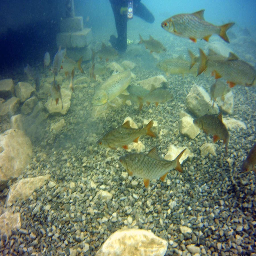

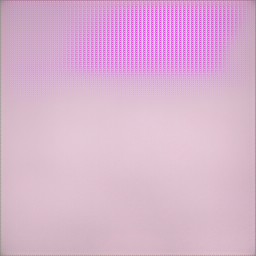

In [17]:
image = os.listdir(train_input_dir)
img =  random.choice(image)
img_dir = train_input_dir + '/' +img
image = cv2.imread(img_dir)
image = cv2.resize(image ,(256,256))
result = get_result(image,plot = False)
cv2_imshow(image)
cv2_imshow(result)
